In [1]:
import pandas as pd

data = pd.read_csv('C:/Users/Wu/Desktop/uOttawa/MDTI/DTI6997 Research Project/Data Cleaned.csv')
data

,Unnamed: 0,Content,Star_rating,Rating
0,0,easy website easy website fast shipping wonder...,4,Great
1,1,hey merry christmas nike hey merry christmas n...,1,Bad
2,2,nike along apple coca cola supporting slavery ...,1,Bad
3,3,ordered shoe 16th day ordered shoe 16th day or...,1,Bad
4,4,bad service good product,1,Bad
...,...,...,...,...
231,231,recommend nikecom give nikecom 5 star always s...,5,Excellent
232,232,great shoe jogger,4,Great
233,233,bought expensive running shoe bought expensive...,1,Bad
234,234,ordered lot site ordered lot site always get g...,5,Excellent


In [2]:
data['Star_rating'] = data['Star_rating'] -1

In [3]:
data

,Unnamed: 0,Content,Star_rating,Rating
0,0,easy website easy website fast shipping wonder...,3,Great
1,1,hey merry christmas nike hey merry christmas n...,0,Bad
2,2,nike along apple coca cola supporting slavery ...,0,Bad
3,3,ordered shoe 16th day ordered shoe 16th day or...,0,Bad
4,4,bad service good product,0,Bad
...,...,...,...,...
231,231,recommend nikecom give nikecom 5 star always s...,4,Excellent
232,232,great shoe jogger,3,Great
233,233,bought expensive running shoe bought expensive...,0,Bad
234,234,ordered lot site ordered lot site always get g...,4,Excellent


# BERT

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
import transformers as trfs
from transformers import BertTokenizer, TFBertModel, BertConfig

In [5]:
import transformers 
import transformers as trfs
num_classes=len(data.Star_rating.unique())
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#bert_model = trfs.TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

In [6]:
sentences=data['Content']
labels_rating=data['Star_rating']
len(sentences),len(labels_rating)

(236, 236)

In [7]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels_rating=np.array(labels_rating)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Wu\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels_rating,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (188, 64) Val input shape (48, 64)
Train label shape (188,) Val label shape (48,)
Train attention mask shape (188, 64) Val attention mask shape (48, 64)


In [9]:
bert_model = trfs.TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes,
                                                                  attention_probs_dropout_prob=0.1,
                                                                  hidden_dropout_prob=0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy')]
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=2,epochs=5,validation_data=([val_inp,val_mask],val_label),
                      callbacks = callbacks)

Epoch 1/5
94/94 [==============================] - 99s 888ms/step - loss: 1.3256 - accuracy: 0.4681 - val_loss: 1.0111 - val_accuracy: 0.7708
Epoch 2/5
94/94 [==============================] - 81s 863ms/step - loss: 0.9733 - accuracy: 0.6436 - val_loss: 0.8204 - val_accuracy: 0.7500


In [11]:
history

In [12]:
from sklearn import metrics
preds = bert_model.predict([val_inp,val_mask],batch_size=2)
pred_labels = np.argmax(preds.logits, axis=1)
print(metrics.classification_report(val_label,pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.81      0.88      0.84        24

    accuracy                           0.75        48
   macro avg       0.34      0.35      0.34        48
weighted avg       0.72      0.75      0.73        48



C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import confusion_matrix 
import numpy as np

cm = confusion_matrix(val_label,pred_labels)
print(cm)

[[15  0  1  0  1]
 [ 1  0  0  0  0]
 [ 0  0  0  2  1]
 [ 0  0  0  0  3]
 [ 1  0  0  2 21]]


<AxesSubplot:>

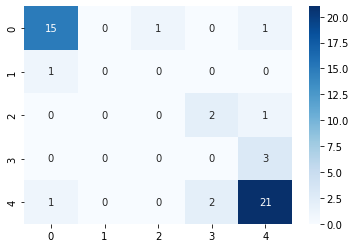

In [14]:
import seaborn as sns
import numpy as np
sns.heatmap(cm, annot=True,  cmap='Blues')

In [15]:
preds.logits

array([[-0.33898512, -1.429492  , -0.31318933, -0.01507185,  0.0211365 ],
       [ 1.9275086 , -0.7308455 , -0.9657937 , -1.1278162 , -0.04357605],
       [-1.465809  , -0.91377956,  0.33127117,  0.8474854 ,  0.22013621],
       [ 2.0356114 , -0.35325664, -0.92944443, -0.97362995, -0.03767537],
       [-1.6026136 , -1.258723  ,  0.06710305,  0.76048905,  0.6824107 ],
       [-1.5579227 , -1.4082282 , -0.02783175,  0.8344845 ,  0.8645972 ],
       [-1.3559352 , -1.6357368 , -0.49377713,  0.6604058 ,  1.5390002 ],
       [-0.8499198 , -1.5365305 , -0.3138421 ,  0.18969135,  1.1764474 ],
       [-0.76417387, -1.719555  , -0.6101762 ,  0.22387652,  1.7361094 ],
       [ 2.0913498 , -0.34928787, -0.9694742 , -1.026795  , -0.05983317],
       [ 1.9088932 , -0.57193255, -0.91181505, -1.0745575 , -0.09587662],
       [ 2.0883095 , -0.34944874, -0.9381955 , -1.0598178 , -0.01031119],
       [-0.14570366, -1.0123057 , -0.0815651 , -0.26284352,  0.2676012 ],
       [ 1.8951652 , -0.42501256, -0.8

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [17]:
# Binarize the output
y_temp = val_label
y_temp = label_binarize(y_temp, classes=[0, 1, 2, 3, 4])
n_classes = y_temp.shape[1]

In [18]:
y_score = preds.logits

In [19]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [20]:
from scipy import interp
from numpy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [21]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

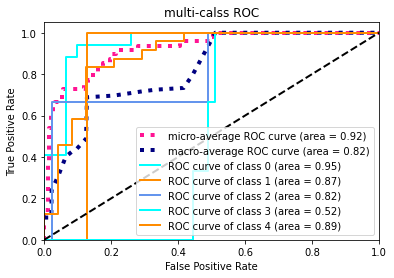

In [22]:
import matplotlib.pyplot as plt
from itertools import cycle
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()